In [1]:
from math import *
import numpy as np
import pandas as pd
from datetime import datetime
import json

import matplotlib.pyplot as plt

import skyfield
from skyfield.api import load
from skyfield.api import N, W, S, E, wgs84
from skyfield.api import Star
from skyfield.data import hipparcos
from skyfield.almanac import find_discrete, risings_and_settings

In [2]:
ts = load.timescale()
eph = load('de421.bsp')

sun = eph['sun']
earth = eph['earth']
mars = eph['mars']
jupiter = eph['JUPITER BARYCENTER']
moon = eph['moon']

with load.open(hipparcos.URL) as f:
    stars_df = hipparcos.load_dataframe(f)
    
star_dictionary = {"Alpheratz":677, "Ankaa":2081, "Schedar":3179, "Diphda":3419, "Achernar":7588, "Hamal":9884, "Polaris":11767, "Acamar":13847, "Menkar":14135, "Mirfak":15863, "Aldebaran":21421, "Rigel":24436, "Capella":24608, "Bellatrix":25336, "Elnath":25428, "Alnilam":26311, "Betelgeuse":27989, "Canopus":30438, "Sirius":32349, "Adhara":33579, "Procyon":37279, "Pollux":37826, "Avior":41037, "Suhail":44816, "Miaplacidus":45238, "Alphard":46390, "Regulus":49669, "Dubhe":54061, "Denebola":57632, "Gienah":59803, "Acrux":60718, "Gacrux":61084, "Alioth":62956, "Spica":65474, "Alkaid":67301, "Hadar":68702, "Menkent":68933, "Arcturus":69673, "Rigil Kent.":71683, "Kochab":72607, "Zuben'ubi":72622, "Alphecca":76267, "Antares":80763, "Atria":82273, "Sabik":84012, "Shaula":85927, "Rasalhague":86032, "Eltanin":87833, "Kaus Aust.":90185, "Vega":91262, "Nunki":92855, "Altair":97649, "Peacock":100751, "Deneb":102098, "Enif":107315, "Al Na'ir":109268, "Fomalhaut":113368, "Scheat":113881, "Markab":113963}

# Kepler 1st Law

Plot out an elpitical orbit from Skyfield by observing earth position at several points during a year.

In [3]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, cos(theta),-sin(theta)],
                   [ 0, sin(theta), cos(theta)]])
 
def Ry(theta):
    return np.matrix([[ cos(theta), 0, sin(theta)],
                   [ 0           , 1, 0           ],
                   [-sin(theta), 0, cos(theta)]])
 
def Rz(theta):
    return np.matrix([[ cos(theta), -sin(theta), 0 ],
                   [ sin(theta), cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def createAngle(degrees, minutes, seconds):
    return (degrees + (minutes + seconds/60.0)/60.0)

In [4]:
t_start = ts.ut1(2021, 1, 1, 0, 0, 0)
t_end = ts.ut1(2022, 1, 1, 0, 0, 0)

time_points = 5000
times = ts.linspace(t_start, t_end, num=time_points)

In [5]:
positions = np.zeros((time_points, 3))

for idx, time in enumerate(times):
    positions[idx] = earth.at(time).xyz.au

# Need to rotate points by earth's axis.
rotationAngle = createAngle(23, 26, 21.448)*-1
rotationMatrix = Rx(radians(rotationAngle))    
positionsRotated = np.asarray(rotationMatrix.dot(positions.T).T)

In [6]:
x = positions[:,0]
y = positions[:,1]
z = positions[:,2]

a = (x.max() - x.min())/2
b = (y.max() - y.min())/2
c = sqrt(pow(a,2)-pow(b,2))
e = c/a

xRot = positionsRotated[:,0]
yRot = positionsRotated[:,1]
zRot = positionsRotated[:,2]

aRot = (xRot.max() - xRot.min())/2
bRot = (yRot.max() - yRot.min())/2
cRot = sqrt(pow(aRot,2)-pow(bRot,2))
eRot = cRot/aRot  # Should be about 0.01671, but can't seem to get to that precision.

print (a, b, c, e)
print (aRot, bRot, cRot, eRot)
print(zRot.max()-zRot.min()) # Should ideally be zero.

0.9993504243687829 0.9168143988914804 0.39768408149097423 0.39794257529050675
0.9993504243687829 0.9992579954485572 0.013591512726612765 0.013600347180717452
0.00013311040003842912


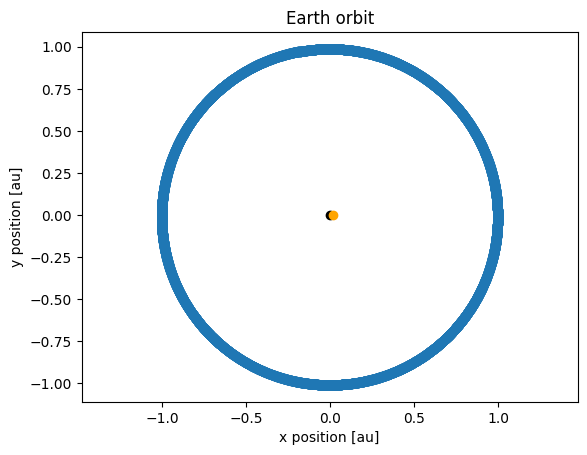

In [7]:
plt.title('Earth orbit')
plt.scatter(0,0, color='black') # true center
plt.scatter(cRot,0, color='orange') # sun position at one of the foci (cRot)
#plt.scatter(-cRot,0, color='orange')
plt.scatter(xRot,yRot)
plt.axis('equal')
plt.xlabel('x position [au]')
plt.ylabel('y position [au]')
plt.show()

# Kepler 3rd Law

In [8]:
k = 0.01720209895
km_in_au = 149600000


sunSolarMass = 1.0
earthSolarMass = 3.00348959632*pow(10, -6)
marsSolarMass = 0.3227151*pow(10, -6)
jupiterSolarMass = 954.79194*pow(10, -6)
moonSolarMass = 1.23000383*pow(10, -8)


def orbitalPeriod (distAU, mass1, mass2):
    return sqrt((4*pow(pi,2))/(pow(k,2)*(mass1+mass2)) * pow(distAU, 3))

In [9]:
#t = ts.ut1(2022, 1, 1, 0, 0, 0)
earthAU = 1.0 #sun.at(t).observe(earth).distance().au
marsAU = 228000000 / km_in_au  #1.52 #sun.at(t).observe(mars).distance().au
jupiterAU = 778000000 / km_in_au  #sun.at(t).observe(jupiter).distance().au
moonAU = 384400 / km_in_au #earth.at(t).observe(moon).distance().au

In [10]:
print("Earth: {} au. P = {}".format(earthAU, orbitalPeriod(earthAU, sunSolarMass, earthSolarMass)))
print("Mars: {} au.  P = {}".format(marsAU, orbitalPeriod(marsAU, sunSolarMass, marsSolarMass)))
print("Jupiter: {} au.  P = {}".format(jupiterAU, orbitalPeriod(jupiterAU, sunSolarMass, jupiterSolarMass)))
print("Moon: {} au.  P = {}".format(moonAU, orbitalPeriod(moonAU, earthSolarMass, moonSolarMass)))

Earth: 1.0 au. P = 365.2563498049167
Mars: 1.5240641711229947 au.  P = 687.2317838271875
Jupiter: 5.2005347593582885 au.  P = 4329.753784984428
Moon: 0.00256951871657754 au.  P = 27.395269867652324
